# COVID-19 Analysis
I will be analyzing COVID-19 data using data from the <a href="https://covidtracking.com/">The COVID Tracking Project</a>.

In [1]:
import os
import datetime
import pandas as pd
import numpy as np
import datetime as dt
import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
import chart_studio.plotly as py #this is to upload the charts to chart studio on plotly

In [2]:
import chart_studio
chart_studio.tools.set_credentials_file(username=os.environ.get('plotly_username'), api_key=os.environ.get('plotly_api_key'))

In [3]:
pd.options.display.max_columns = 75
pd.options.display.max_rows = 50
pd.options.display.max_colwidth = 50

# US National Data

I'll start this analysis by first looking at the US National Data. The COVID Tracking Project has a public API and we can simply pass in the URL to the pandas read json function to get the data into a DataFrame.

In [4]:
us_daily_df = pd.read_json('https://api.covidtracking.com/v1/us/daily.json')

us_daily_df['date'] = pd.to_datetime(us_daily_df['date'],format='%Y%m%d')

I want to calculate a few key metrics and will create a few variables to hold some dates. Specifically, they will hold yesterdays date, the day before yesterday, and one week ago.

In [5]:
#Here is a quick way to generate a date range to pull key stats for certain time ranges 
dates_days = pd.date_range(start='1/31/2020', end= dt.datetime.now())

yesterday = dates_days[-2]
two_days_ago = dates_days[-3]
one_week_ago = dates_days[-8]

us_daily_df.set_index('date', drop=True, inplace=True)

us_daily_df.sort_index(inplace=True)

In [6]:
us_daily_df.tail()

states  positive   negative  pending  hospitalizedCurrently  \
date                                                                      
2020-11-30      56  13338607  153863841  14883.0                96149.0   
2020-12-01      56  13515360  155805555   8764.0                98777.0   
2020-12-02      56  13711156  156787587  14368.0               100322.0   
2020-12-03      56  13921360  158026052  15106.0               100755.0   
2020-12-04      56  14146191  159286709  12714.0               101276.0   

            hospitalizedCumulative  inIcuCurrently  inIcuCumulative  \
date                                                                  
2020-11-30                559871.0         18801.0          30469.0   
2020-12-01                565093.0         19295.0          30749.0   
2020-12-02                570121.0         19680.0          31038.0   
2020-12-03                575452.0         19723.0          31276.0   
2020-12-04                580104.0         19858.0          31608.0   

            onVentilatorCurrently  onVentilatorCumulative  recovered  \
date                                                                   
2020-11-30                 6520.0                  3205.0  5146643.0   
2020-12-01                 6649.0                  3223.0  5226581.0   
2020-12-02                 6855.0                  3252.0  5322128.0   
2020-12-03                 6867.0                  3280.0  5404018.0   
2020-12-04                 6999.0                  3305.0  5470389.0   

                     dateChecked     death  hospitalized  totalTestResults  \
date                                                                         
2020-11-30  2020-11-30T24:00:00Z  259316.0      559871.0         192776284   
2020-12-01  2020-12-01T24:00:00Z  261789.0      565093.0         195117280   
2020-12-02  2020-12-02T24:00:00Z  264522.0      570121.0         196576482   
2020-12-03  2020-12-03T24:00:00Z  267228.0      575452.0         198404712   
2020-12-04  2020-12-04T24:00:00Z  269791.0      580104.0         200259581   

                    lastModified  total  posNeg  deathIncrease  \
date                                                             
2020-11-30  2020-11-30T24:00:00Z      0       0           1136   
2020-12-01  2020-12-01T24:00:00Z      0       0           2473   
2020-12-02  2020-12-02T24:00:00Z      0       0           2733   
2020-12-03  2020-12-03T24:00:00Z      0       0           2706   
2020-12-04  2020-12-04T24:00:00Z      0       0           2563   

            hospitalizedIncrease  negativeIncrease  positiveIncrease  \
date                                                                   
2020-11-30                  3394           1219808            147587   
2020-12-01                  5222           1941714            176753   
2020-12-02                  5028            982032            195796   
2020-12-03                  5331           1238465            210204   
2020-12-04                  4652           1260657            224831   

            totalTestResultsIncrease                                      hash  
date                                                                            
2020-11-30                   1603253  6ab94db6e497c806f0a63f2125ba392ea3b4093e  
2020-12-01                   2340996  f15ac17558a7a0296208371cfddab34c032e5bc8  
2020-12-02                   1459202  477c17b6302d0485195e77ecf8270a974f7a3c82  
2020-12-03                   1828230  0f253d185ecb336cdd18a4c61996eda1b7eef13b  
2020-12-04                   1854869  ae30ea088584335ba4d57ee927f8dbda6add74db

Taking a look at the data, we can see that it is cumulative. Since I want to analyze number of new cases and deaths each day, I'll have to subtract the previous row. I will take advantage of the <code>DataFrame.diff()</code> to handle that calculation.

In [7]:
us_daily_df_new_per_day = us_daily_df[['positive','hospitalizedCumulative','death']].diff(periods=1)

us_daily_df_new_per_day_rolling = us_daily_df_new_per_day.rolling(window=7).mean()

The following functions add some formatting and context to the key stats.

In [8]:
def change_text(change):
    '''
    These functions will appear below the key stats to show the trend
    '''
    if change > 0:
        return "↑ " + str("{:.0%}".format(change)+' 7-day Trend')
    elif change < 0:
        return "↓ " + str("{:}%".format(change)+' 7-day Trend')
    elif change == 0:
        return "No Change 7-day Trend"
    else:
        pass

def change_color(change):
    '''
    This function defines the % change subtext in the top stats part
    '''
    if change > 0:
        return "red"
    elif change < 0:
        return "green"
    elif change == 0:
        return "grey"
    else:
        pass


Next, I will return the positive, death, and hospitalized stats for yesterday and then compare that to the 7 day trend.

In [9]:
#Here is where I will be dynamically calculating yesterdays stats along with the trends.

us_cases_yesterday = us_daily_df_new_per_day.loc[yesterday]['positive']
us_cases_death = us_daily_df_new_per_day.loc[yesterday]['death']
us_cases_hospitalized = us_daily_df_new_per_day.loc[yesterday]['hospitalizedCumulative']

us_cases_seven_day_trend = us_daily_df_new_per_day_rolling.loc[yesterday]['positive'] / us_daily_df_new_per_day_rolling.loc[one_week_ago]['positive'] - 1
us_death_seven_day_trend = us_daily_df_new_per_day_rolling.loc[yesterday]['death'] / us_daily_df_new_per_day_rolling.loc[one_week_ago]['death'] - 1
us_hospitalized_seven_day_trend = us_daily_df_new_per_day_rolling.loc[yesterday]['hospitalizedCumulative'] / us_daily_df_new_per_day_rolling.loc[one_week_ago]['hospitalizedCumulative'] - 1

Now, I will take the stats from yesterday and the trends and put them into an HTML table using Plotly.

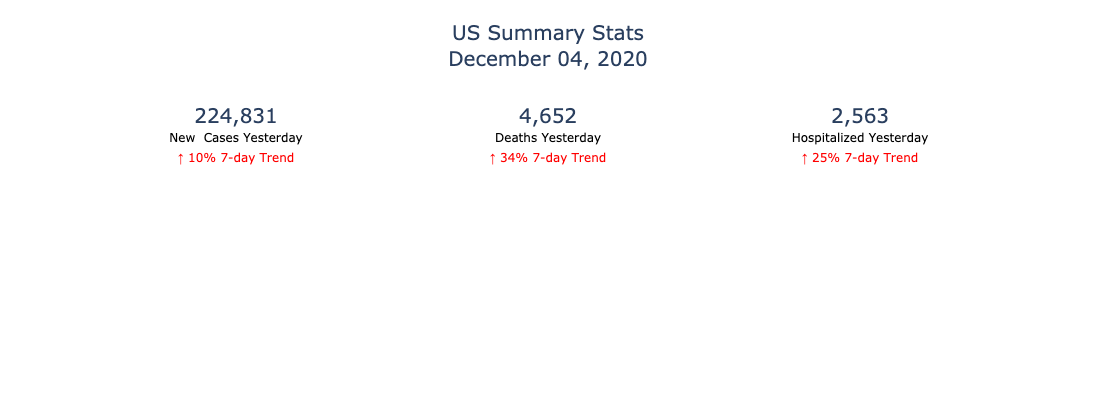

In [10]:
fig0 = go.Figure(data=[go.Table(
    header=dict(values=['{:,}'.format(int(us_cases_yesterday)), '{:,}'.format(int(us_cases_hospitalized)), '{:,}'.format(int(us_cases_death))],
                fill_color='white',
                align='center',
               font_size=20,
                   height=25),
    cells=dict(values=[['New  Cases Yesterday', change_text(us_cases_seven_day_trend)], # 1st column
                       ['Deaths Yesterday', change_text(us_death_seven_day_trend)],
                      ['Hospitalized Yesterday',change_text(us_hospitalized_seven_day_trend)]], # 2nd column
               fill_color='white',
               font_color=[['black',change_color(us_cases_seven_day_trend)],['black',change_color(us_death_seven_day_trend)],['black',change_color(us_hospitalized_seven_day_trend)]],
               align='center')),
    
])

fig0.update_layout(height=400, autosize=True, title={
        'text': "US Summary Stats<br>"+ yesterday.strftime("%B %d, %Y"),
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font_size':20})

py.iplot(fig0, filename = 'us_summary_stats')

fig0.show()

Next, I will chart the new daily positive cases along with the seven day moving average. I'll repeat this for the deaths and hospitalized as well. New daily data has some noise so the moving average is a better indicator of the trend. An example of the noise in the daily average is that you will notice how cases go down over the weekend which probably has to do with reporting than less people getting sick.

I am using the charting library from <a href="https://plotly.com/">Plotly</a> which is an interactive charting library for Python. It uses pretty similiar syntax to seaborn and the charts plotly spits out do not require nearly as much wrangling as they do in Seaborn/MatPlotLib. These interactive charts give you the ability to do the following:
<ul>
    <li>Hover over to see the data labels</li>
    <li>Click and drag to zoom into an area</li>
    <li>Click on the legend items to hide that chart</li>
</ul>

There are a few others cool things you can do with the chart as well but I'll leave it up to you to go learn more about it by playing around with them.

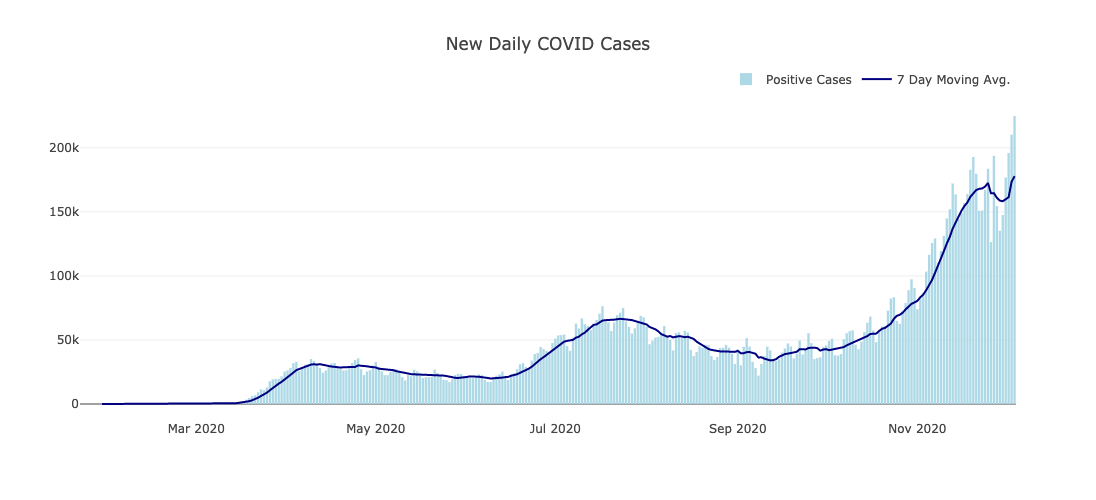

In [11]:
fig1 = go.Figure()
fig1.add_trace(go.Bar(x=us_daily_df_new_per_day.index, 
                      y=us_daily_df_new_per_day['positive'], 
                      marker_color='lightblue', 
                      name= 'Positive Cases',
                      hovertemplate = '%{y:,.0f}'
                     ))
fig1.add_trace(go.Scatter(x=us_daily_df_new_per_day_rolling.index, 
                          y=us_daily_df_new_per_day_rolling['positive'], 
                          marker_color='#000080', 
                          name = '7 Day Moving Avg.',
                         hovertemplate ='%{y:,.0f}'))


fig1.update_layout(template='none', height=500, autosize=True,hovermode="x unified", title='New Daily COVID Cases',legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))
py.iplot(fig1, filename = 'us_new_daily_covid_cases')
fig1.show()

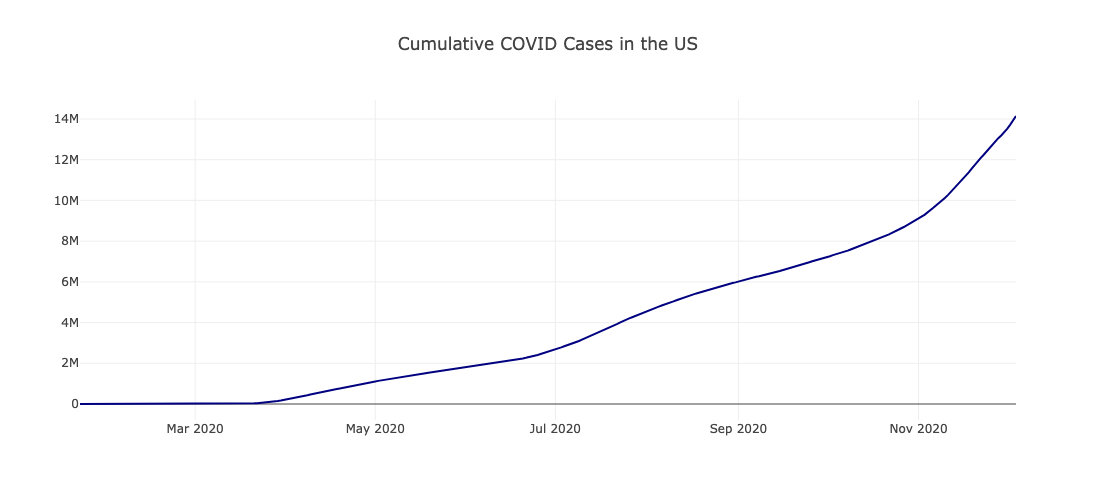

In [12]:
fig10 = go.Figure()

fig10.add_trace(go.Scatter(x=us_daily_df.index, 
                          y=us_daily_df['positive'], 
                          marker_color='#000080', 
                          name = 'Total Cases',
                         hovertemplate ='%{y:,.0f}'))


fig10.update_layout(template='none', height=500, autosize=True,hovermode="x unified", title='Cumulative COVID Cases in the US',legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))
py.iplot(fig10, filename = 'us_cumulative_covid_cases')
fig10.show()

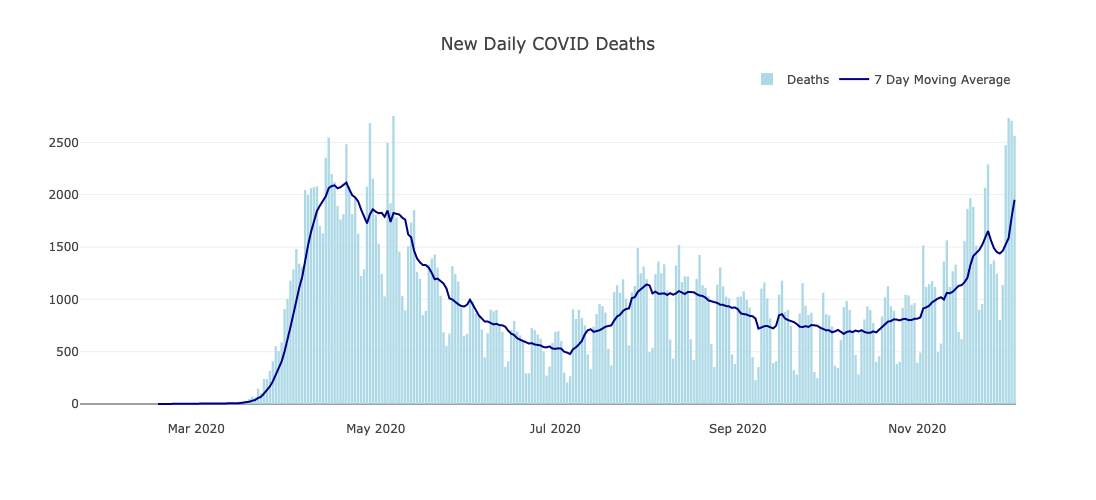

In [13]:
fig2 = go.Figure()
fig2.add_trace(go.Bar(x=us_daily_df_new_per_day.index, 
                      y=us_daily_df_new_per_day['death'], 
                      marker_color='lightblue', 
                      name= 'Deaths',
                     hovertemplate ='%{y:,.0f}'))

fig2.add_trace(go.Scatter(x=us_daily_df_new_per_day_rolling.index, 
                          y=us_daily_df_new_per_day_rolling['death'], 
                          marker_color='#000080', 
                          name = '7 Day Moving Average',
                         hovertemplate ='%{y:,.0f}'))


fig2.update_layout(template='none', height=500, autosize=True, hovermode= 'x unified', title='New Daily COVID Deaths',legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))
py.iplot(fig2, filename = 'us_new_daily_covid_deaths')
fig2.show()

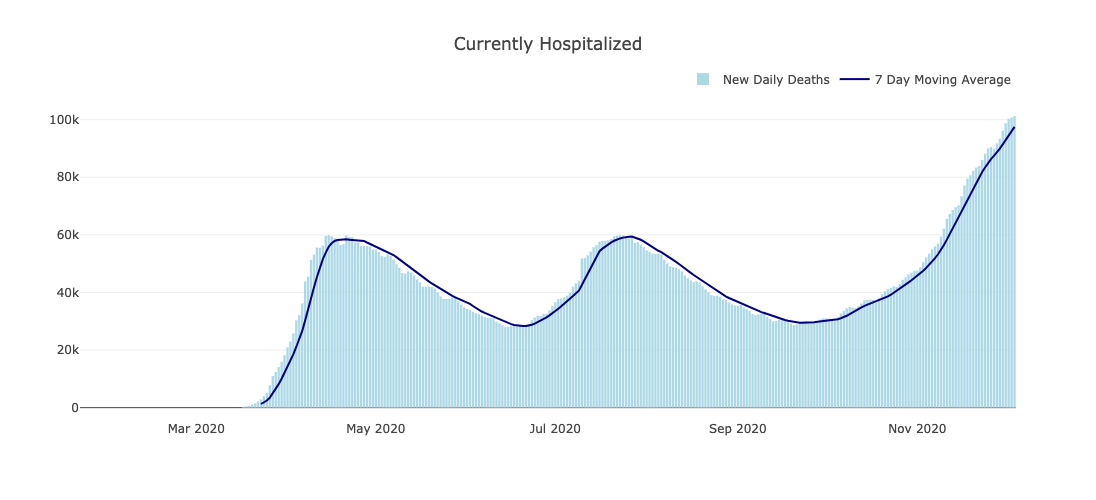

In [14]:
fig3 = go.Figure()


fig3.add_trace(go.Bar(x=us_daily_df.index, 
                      y=us_daily_df['hospitalizedCurrently'], 
                      marker_color='lightblue', 
                      name= 'New Daily Deaths',
                     hovertemplate ='%{y:,.0f}'))

df = us_daily_df[['hospitalizedCurrently']].rolling(window=7).mean()
fig3.add_trace(go.Scatter(x=df.index, 
                          y=df['hospitalizedCurrently'], 
                          marker_color='#000080', 
                          name = '7 Day Moving Average',
                         hovertemplate ='%{y:,.0f}'))


fig3.update_layout(template='none', height=500, autosize=True, hovermode= 'x unified', title='Currently Hospitalized',legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))
py.iplot(fig3, filename = 'us_new_daily_covid_hospitalized')
fig3.show()

# State Data

Now we can turn our attention to the state data to see where the virus is hitting the hardest. There is a seperate API link to pull the state data.

In [15]:
us_states_cases_df = pd.read_json('https://api.covidtracking.com/v1/states/daily.json')

In [16]:
us_states_cases_df['date'] = pd.to_datetime(us_states_cases_df['date'],format='%Y%m%d')

In [17]:
us_states_cases_df.sort_values(by='date', ascending=True, inplace=True)

The State data is also cumulative which means we have to subtract the rows from the previous row to get the new daily numbers. However, there is a twist. We need to make sure that we subtract the row only if it's from the same state. So in order to do that, I will first re-index the DataFrame with the stat and the date as a multi-index. A multi-index just means that there are two levels of indexing.

In [18]:
us_states_cases_df.set_index(['state','date'], drop=True, inplace=True)

In [19]:
state_list = us_states_cases_df.index.get_level_values(level=0).unique().tolist()

Now, we can create a function that loops through the DataFrame, isolates a state, and then runs the <code>DataFrame.diff()</code> function along with the <code>DataFrame.rolling()</code> function to calculate the seven day moving average. 

In [20]:
def new_daily_cases(lst):
    '''
    Since the data is cumluative, this function calculates the daily change
    '''
    
    df_new_cases = pd.DataFrame()
    df_new_cases_rolling = pd.DataFrame()
    
    for i in lst:
        state_df = us_states_cases_df[us_states_cases_df.index.isin([i], level=0)][['positive','hospitalizedCumulative','death']].diff(periods=1)
        df_new_cases = pd.concat([df_new_cases,state_df])
        
        df_rolling = state_df.rolling(window=7).mean()
        df_new_cases_rolling = pd.concat([df_new_cases_rolling,df_rolling])
        
    return df_new_cases, df_new_cases_rolling
    

In [21]:
us_state_daily_cases, us_state_daily_cases_rolling = new_daily_cases(state_list)

In [22]:
us_state_and_rolling = pd.merge(us_state_daily_cases, us_state_daily_cases_rolling, how='inner', left_index=True, right_index=True, suffixes = ['_new','_rolling'])

The number of COVID cases will naturally be higher in states with a higher population so I am bringing in data to normalize it so we can see which states are being hit the hardest per capita. I grabbed the state population data from this <a href="https://www.infoplease.com/us/states/state-population-by-rank">site</a>. In order to join the data with my original DataFrame I need to translate the state abbreviations to state names. So I need to create a mapping to do that. I use this <a href="https://www.ssa.gov/international/coc-docs/states.html">site</a> for the translations. An easy way to get these into a DataFrame is to highlight and copy the data and then use the the <code>pd.from_clipboard()</code> to create a DataFrame.

In [23]:
state_codes = pd.DataFrame({'state_name': {0: 'Alabama', 1: 'Alaska', 2: 'American Samoa', 3: 'Arizona', 4: 'Arkansas', 5: 'California', 6: 'Colorado', 7: 'Connecticut', 8: 'Delaware', 9: 'District Of Columbia', 10: 'Florida', 11: 'Georgia', 12: 'Guam', 13: 'Hawaii', 14: 'Idaho', 15: 'Illinois', 16: 'Indiana', 17: 'Iowa', 18: 'Kansas', 19: 'Kentucky', 20: 'Louisiana', 21: 'Maine', 22: 'Maryland', 23: 'Massachusetts', 24: 'Michigan', 25: 'Minnesota', 26: 'Mississippi', 27: 'Missouri', 28: 'Montana', 29: 'Nebraska', 30: 'Nevada', 31: 'New Hampshire', 32: 'New Jersey', 33: 'New Mexico', 34: 'New York', 35: 'North Carolina', 36: 'North Dakota', 37: 'Northern Mariana Is', 38: 'Ohio', 39: 'Oklahoma', 40: 'Oregon', 41: 'Pennsylvania', 42: 'Puerto Rico', 43: 'Rhode Island', 44: 'South Carolina', 45: 'South Dakota', 46: 'Tennessee', 47: 'Texas', 48: 'Utah', 49: 'Vermont', 50: 'Virginia', 51: 'Virgin Islands', 52: 'Washington', 53: 'West Virginia', 54: 'Wisconsin', 55: 'Wyoming'}, 'abbreviation': {0: 'AL', 1: 'AK', 2: 'AS', 3: 'AZ', 4: 'AR', 5: 'CA', 6: 'CO', 7: 'CT', 8: 'DE', 9: 'DC', 10: 'FL', 11: 'GA', 12: 'GU', 13: 'HI', 14: 'ID', 15: 'IL', 16: 'IN', 17: 'IA', 18: 'KS', 19: 'KY', 20: 'LA', 21: 'ME', 22: 'MD', 23: 'MA', 24: 'MI', 25: 'MN', 26: 'MS', 27: 'MO', 28: 'MT', 29: 'NE', 30: 'NV', 31: 'NH', 32: 'NJ', 33: 'NM', 34: 'NY', 35: 'NC', 36: 'ND', 37: 'MP', 38: 'OH', 39: 'OK', 40: 'OR', 41: 'PA', 42: 'PR', 43: 'RI', 44: 'SC', 45: 'SD', 46: 'TN', 47: 'TX', 48: 'UT', 49: 'VT', 50: 'VA', 51: 'VI', 52: 'WA', 53: 'WV', 54: 'WI', 55: 'WY'}})

In [24]:
state_populations = pd.DataFrame({'State': {0: 'California', 1: 'Texas', 2: 'Florida', 3: 'New York', 4: 'Illinois', 5: 'Pennsylvania', 6: 'Ohio', 7: 'Georgia', 8: 'North Carolina', 9: 'Michigan', 10: 'New Jersey', 11: 'Virginia', 12: 'Washington', 13: 'Arizona', 14: 'Massachusetts', 15: 'Tennessee', 16: 'Indiana', 17: 'Missouri', 18: 'Maryland', 19: 'Wisconsin', 20: 'Colorado', 21: 'Minnesota', 22: 'South Carolina', 23: 'Alabama', 24: 'Louisiana', 25: 'Kentucky', 26: 'Oregon', 27: 'Oklahoma', 28: 'Connecticut', 29: 'Utah', 30: 'Iowa', 31: 'Nevada', 32: 'Arkansas', 33: 'Mississippi', 34: 'Kansas', 35: 'New Mexico', 36: 'Nebraska', 37: 'West Virginia', 38: 'Idaho', 39: 'Hawaii', 40: 'New Hampshire', 41: 'Maine', 42: 'Montana', 43: 'Rhode Island', 44: 'Delaware', 45: 'South Dakota', 46: 'North Dakota', 47: 'Alaska', 48: 'DC', 49: 'Vermont', 50: 'Wyoming'}, 'July 2019 Estimate': {0: 39512223.0, 1: 28995881.0, 2: 21477737.0, 3: 19453561.0, 4: 12671821.0, 5: 12801989.0, 6: 11689100.0, 7: 10617423.0, 8: 10488084.0, 9: 9986857.0, 10: 8882190.0, 11: 8535519.0, 12: 7614893.0, 13: 7278717.0, 14: 6949503.0, 15: 6833174.0, 16: 6732219.0, 17: 6137428.0, 18: 6045680.0, 19: 5822434.0, 20: 5758736.0, 21: 5639632.0, 22: 5148714.0, 23: 4903185.0, 24: 4648794.0, 25: 4467673.0, 26: 4217737.0, 27: 3956971.0, 28: 3565287.0, 29: 3205958.0, 30: 3155070.0, 31: 3080156.0, 32: 3017825.0, 33: 2976149.0, 34: 2913314.0, 35: 2096829.0, 36: 1934408.0, 37: 1792147.0, 38: 1787065.0, 39: 1415872.0, 40: 1359711.0, 41: 1344212.0, 42: 1068778.0, 43: 1059361.0, 44: 973764.0, 45: 884659.0, 46: 762062.0, 47: 731545.0, 48: 705749.0, 49: 623989.0, 50: 578759.0}})

In [25]:
us_state_and_rolling_reset = us_state_and_rolling.reset_index()

us_states_daily_df_codes = pd.merge(us_state_and_rolling_reset,state_codes,how='inner',left_on='state',right_on='abbreviation')

us_states_daily_df_population = pd.merge(us_states_daily_df_codes,state_populations,how='inner',left_on='state_name',right_on='State')


To normalize the COVID cases by state population, I'll divide the new cases by the state poplution and then divide that by 100,000 to get new cases per 100,000 people.

In [26]:
us_states_daily_df_population['cases_per_hundred_thousand'] = us_states_daily_df_population['positive_new'] / (us_states_daily_df_population['July 2019 Estimate'] / 100000)

Now let's take a look at which states have the highest infection rate per 100,000 people.

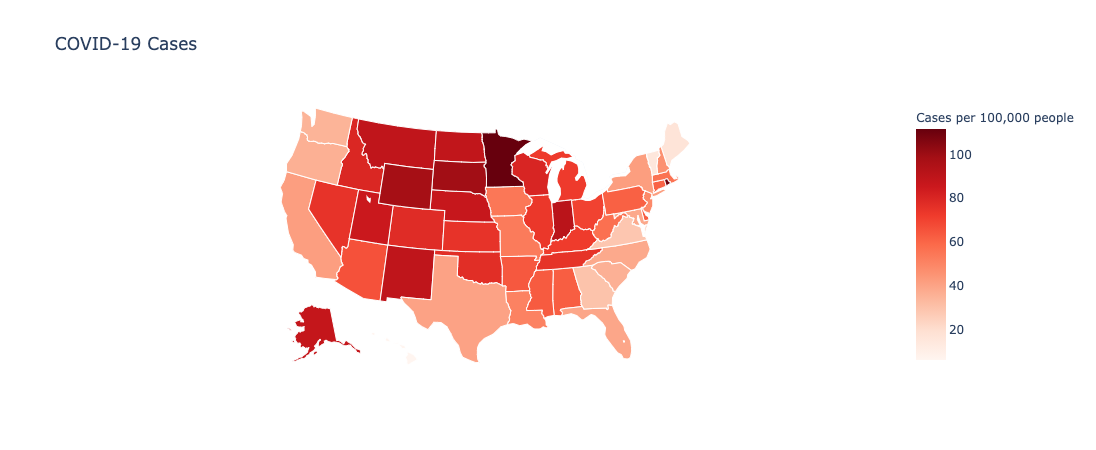

In [27]:
##Yesterdays average
#df = us_states_daily_df_population[us_states_daily_df_population['date'] == yesterday]

##One week average
df = us_states_daily_df_population[us_states_daily_df_population['date'] >= one_week_ago].groupby(['state','state_name']).mean().reset_index()

df['text'] = df.apply(lambda x: x['state_name'] +'<br>' + 'New Cases Last 7 Days Avg: ' + '{:,.0f}'.format(x['positive_new']) + '<br>' + 'Per 100,000 people: ' + '{:,.0f}'.format(x['cases_per_hundred_thousand']),axis=1)
#df['state_name'] + '<br>' + 'Last 7 Days Average ' + df['positive_new'].astype('str') + '<br>' + 'Per 100,000 ' + df['cases_per_hundred_thousand'].astype('str')

fig4 = go.Figure(data=go.Choropleth(
    locations=df['state'],
    z=df['cases_per_hundred_thousand'],
    locationmode='USA-states',
    colorscale='Reds',
    autocolorscale=False,
    text=df['text'], # hover text
    marker_line_color='white', # line markers between states
    colorbar_title="Cases per 100,000 people",
    hoverinfo="text"
))

fig4.update_layout(
    title_text='COVID-19 Cases',
    geo = dict(
        scope='usa',
        projection=go.layout.geo.Projection(type = 'albers usa'),
        showlakes=True, # lakes
        lakecolor='rgb(255, 255, 255)'),
)

py.iplot(fig4, filename = 'covid_cases_by_state_map')
fig4.show()

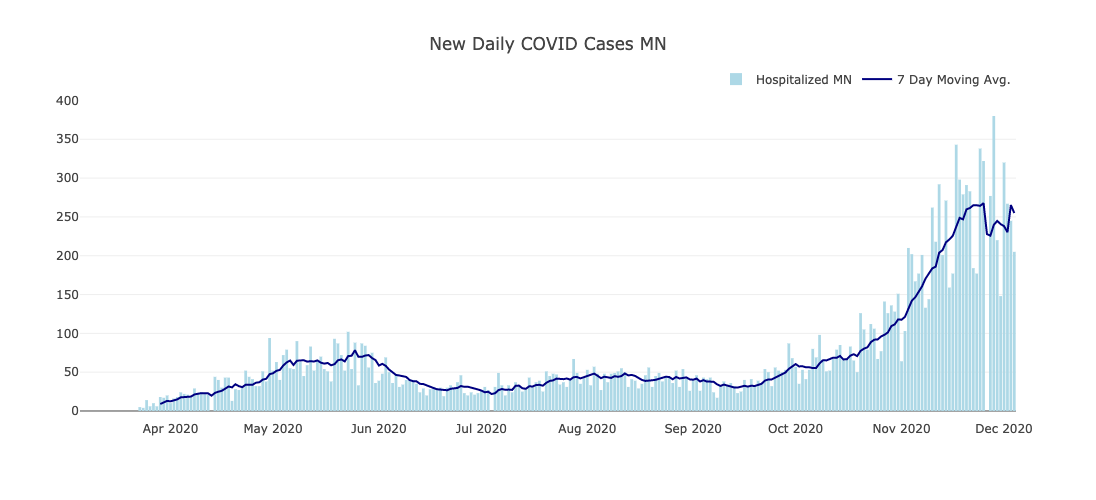

In [28]:
# I am just isolating a state here to take a look and make sure the data looks right
state = 'MN'
stat_type = 'Hospitalized'

df_single_state = us_state_daily_cases.loc[state].rename(columns={'positive':'New Cases','hospitalizedCumulative':'Hospitalized','death':'Deaths'})
df_rolling_single_state = us_state_daily_cases_rolling.loc[state].rename(columns={'positive':'New Cases','hospitalizedCumulative':'Hospitalized','death':'Deaths'})

fig6 = go.Figure()

fig6.add_trace(go.Bar(x=df_single_state.index, 
                      y=df_single_state[stat_type], 
                      marker_color='lightblue', 
                      name= stat_type+' '+state,
                      hovertemplate ='%{y:,.0f}'))

fig6.add_trace(go.Scatter(x=df_rolling_single_state.index, 
                          y=df_rolling_single_state[stat_type], 
                          marker_color='#000080', 
                          name = '7 Day Moving Avg.',
                          hovertemplate ='%{y:,.0f}'))


fig6.update_layout(template='none', height=500, autosize=True, hovermode= 'x unified', title='New Daily COVID Cases '+ state,legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))
fig6.show()

Next, I am creating ten subplots to take a look at the states with the highest infection rates.

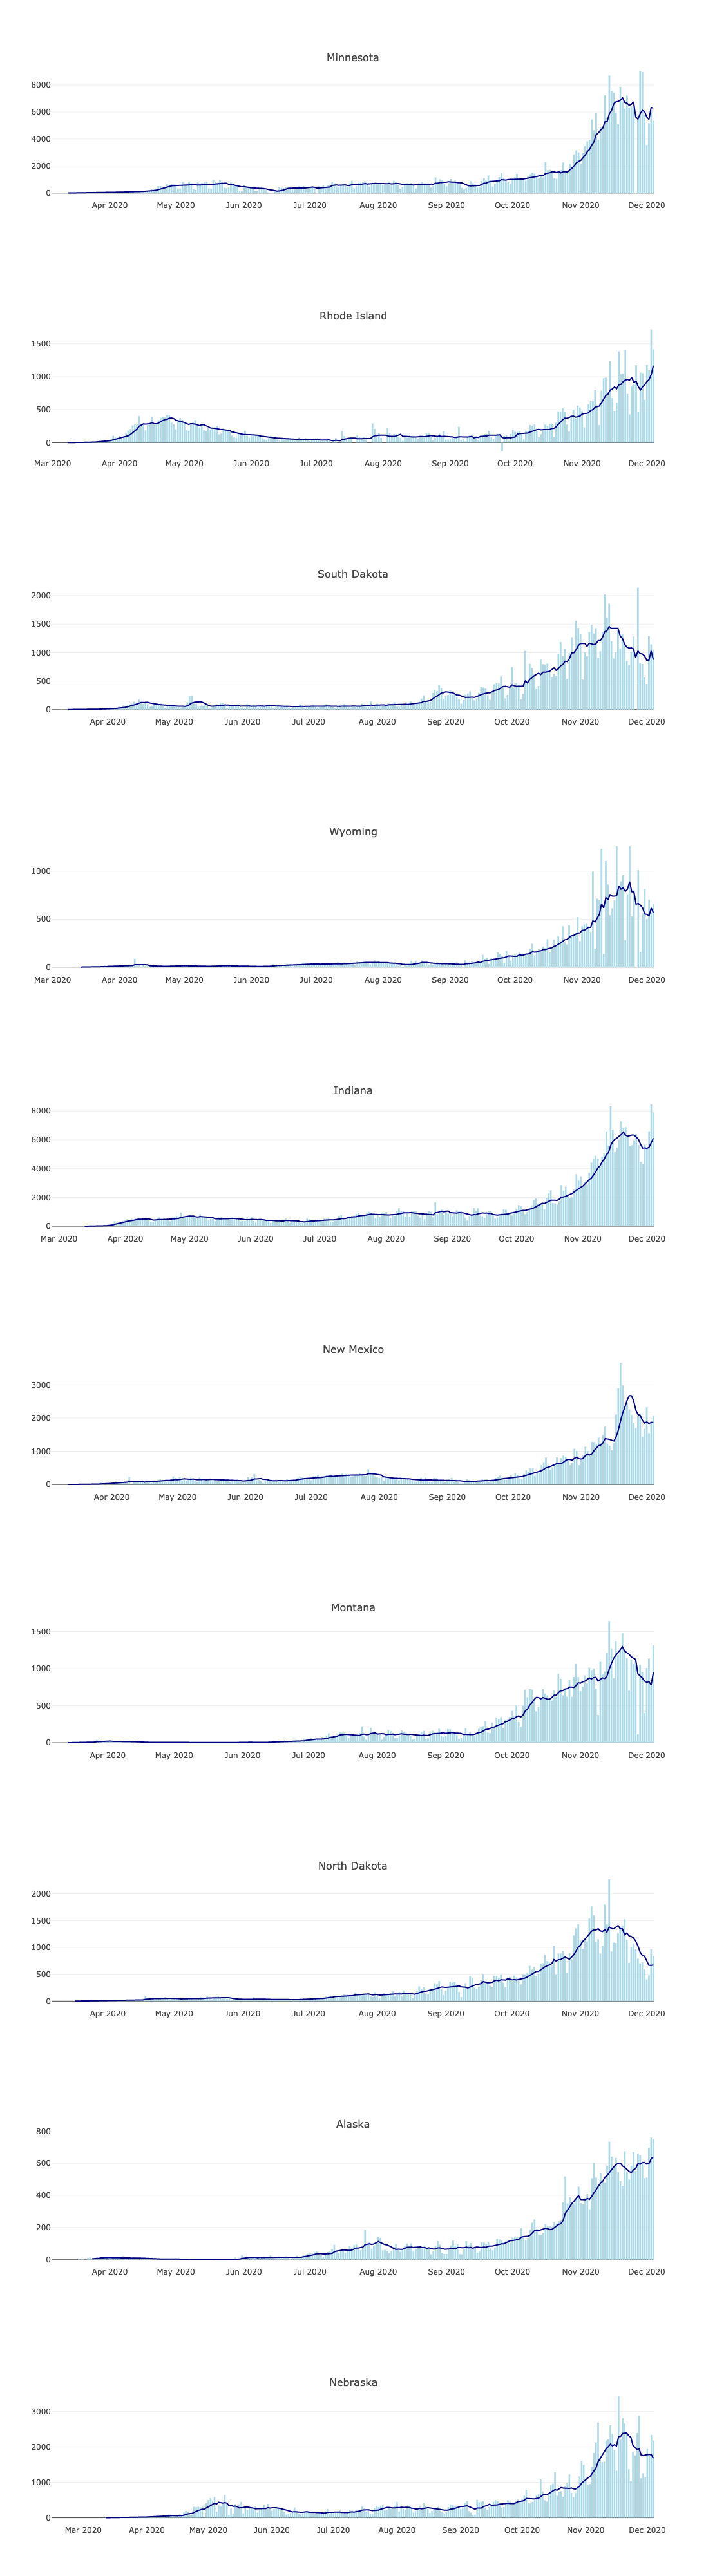

In [29]:
df = us_states_daily_df_population[us_states_daily_df_population['date'] >= one_week_ago].groupby(['state','state_name']).mean().reset_index()

state_list_sorted =  df.sort_values(by='cases_per_hundred_thousand', ascending=False)['state'].to_list()
state_names_list_sorted = df.sort_values(by='cases_per_hundred_thousand', ascending=False)['state_name'].to_list()

from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig5 = make_subplots(rows=len(state_list_sorted[:10]), cols=1, subplot_titles=state_names_list_sorted[:10])

for i in state_list_sorted[:10]:
    df = us_state_daily_cases.loc[i]
    df_rolling = us_state_daily_cases_rolling.loc[i]
    
    fig5.add_trace(go.Bar(x=df.index, 
                          y=df['positive'], 
                          marker_color='lightblue', 
                          name= 'New Daily Cases -'+i,
                          hovertemplate ='%{y:,.0f}'),
                          row=state_list_sorted.index(i)+1, col=1)
    
    fig5.add_trace(go.Scatter(x=df_rolling.index, 
                              y=df_rolling['positive'], 
                              marker_color='#000080', 
                              name = '7 Day Moving Avg.',
                              hovertemplate ='%{y:,.0f}'), 
                              row=state_list_sorted.index(i)+1, col=1)


fig5.update_layout(template='none', height=4000, autosize=True, hovermode= 'x unified', showlegend=False
                  # title={'text': "Positives by State<br>Sorted by Highest Cases per 100,000 people",'y':0.998,'x':0.5,'xanchor': 'center','yanchor': 'top'}
                  )

py.iplot(fig5, filename = 'covid_cases_by_state_subplots_top_10')

fig5.show()   



Here is a look at the ten states with the lowest infection rates per 100,000 people.

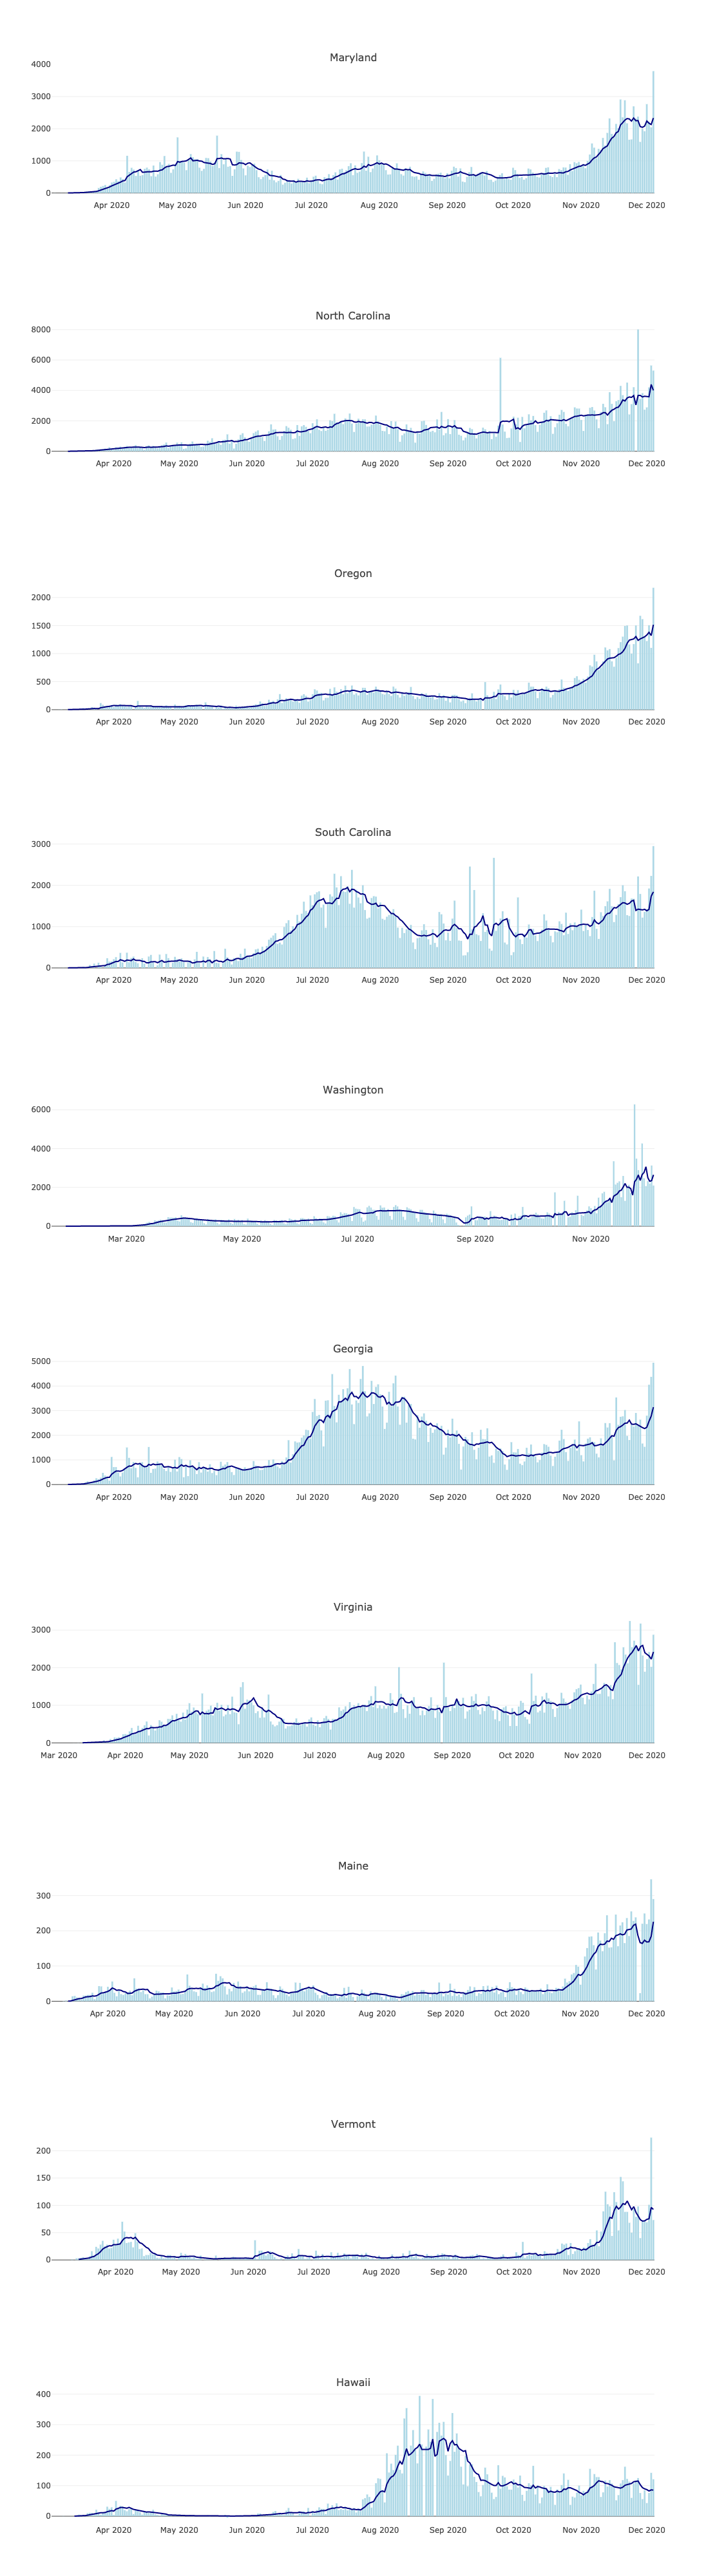

In [30]:
df = us_states_daily_df_population[us_states_daily_df_population['date'] >= one_week_ago].groupby(['state','state_name']).mean().reset_index()

state_list_sorted =  df.sort_values(by='cases_per_hundred_thousand', ascending=False)['state'].to_list()
state_names_list_sorted = df.sort_values(by='cases_per_hundred_thousand', ascending=False)['state_name'].to_list()

from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig6 = make_subplots(rows=len(state_list_sorted[-10:]), cols=1, subplot_titles=state_names_list_sorted[-10:])

for i in state_list_sorted[-10:]:
    df = us_state_daily_cases.loc[i]
    df_rolling = us_state_daily_cases_rolling.loc[i]
    
    fig6.add_trace(go.Bar(x=df.index, 
                          y=df['positive'], 
                          marker_color='lightblue', 
                          name= 'New Daily Cases -'+i,
                          hovertemplate ='%{y:,.0f}'),
                          row=state_list_sorted[-10:].index(i)+1, col=1)
    
    fig6.add_trace(go.Scatter(x=df_rolling.index, 
                              y=df_rolling['positive'], 
                              marker_color='#000080', 
                              name = '7 Day Moving Avg.',
                              hovertemplate ='%{y:,.0f}'), 
                              row=state_list_sorted[-10:].index(i)+1, col=1)


fig6.update_layout(template='none', height=4000, autosize=True, hovermode= 'x unified', showlegend=False
                  # title={'text': "Positives by State<br>Sorted by Highest Cases per 100,000 people",'y':0.998,'x':0.5,'xanchor': 'center','yanchor': 'top'}
                  )

py.iplot(fig6, filename = 'covid_cases_by_state_subplots_bottom_10')

fig6.show()   



# Export to HTML file
Finally, we can to export the just the charts as an HTML file. Plotly's interactive charts remain interactive in an HTML export. 

In [31]:
os.remove('covid_dashboard.html')

with open('covid_dashboard.html', 'a') as f:
    f.write("<style>* { font-family: 'Helvetica Neue'} </style>")
    f.write("<h1>COVID-19 Dashboard<h1>")
    f.write("<h3>"+datetime.datetime.now().strftime("%B %d, %Y")+"<h3>")
    f.write(fig1.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(fig2.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(fig3.to_html(full_html=False, include_plotlyjs='cdn'))

Thanks for reading!